<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/classification_noisy_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with noisy labels
## Scott Spurlock
### 12-17-2020


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os 
root_dir = "/content/drive/My Drive/Research/deepfakes/"
os.chdir(root_dir)

!pwd

/content/drive/My Drive/Research/deepfakes


In [5]:
!ls

classification_noisy_labels.ipynb  papers  scratch.py


In [6]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Shuffle
# from sklearn.utils import shuffle
# x_train, y_train = shuffle(x_train, y_train, random_state=0)
# print(x_train.shape)
# rp = np.random.permutation(len(x_train))


11493376/11490434 [==============================] - 0s 0us/step


## Keep only two classes for binary classification

In [7]:
# Only keep 2 classes
mask1 = y_train == 4
mask2 = y_train == 7
mask = mask1 | mask2
y_train[mask1] = 0
y_train[mask2] = 1
y_train = y_train[mask]
x_train = x_train[mask]

mask1 = y_test == 4
mask2 = y_test == 7
mask = mask1 | mask2
y_test[mask1] = 0
y_test[mask2] = 1
y_test = y_test[mask]
x_test = x_test[mask]

u = np.unique(y_train)
num_classes = len(u)


In [8]:
y_train.shape

(12107,)

In [9]:

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")



x_train shape: (12107, 28, 28, 1)
12107 train samples
2010 test samples


In [11]:
# Subsample data
keep_frac = 1
n = int(len(x_train) * keep_frac)
x_train = x_train[:n]
y_train = y_train[:n]

print(y_train.shape)
print(x_train.shape)

(12107,)
(12107, 28, 28, 1)


## Change labels
Change a fraction of the labels from class 0 to class 1.

In [12]:
# Corrupt labels
change_frac = 0.5
# m = int(n * change_frac)
# rp = np.random.permutation(n)[:m]
# new_labels = np.random.randint(0, num_classes, m)
# y_train[rp] = new_labels
# print(y_train.shape)

# Randomly switch some negative examples to be positive
for i in range(len(y_train)):
  if (y_train[i] == 0 and np.random.random() < change_frac):
    y_train[i] = 1


In [13]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)


(12107, 28, 28, 1)
(12107, 2)


## Baseline model

In [14]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3

## TODO: keep a validation set that isn't corrupted.

In [15]:
batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
86/86 [==============================] - 8s 10ms/step - loss: 0.4796 - accuracy: 0.7505 - val_loss: 0.3610 - val_accuracy: 0.7465
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3662 - accuracy: 0.7639 - val_loss: 0.3522 - val_accuracy: 0.7547
Epoch 3/5
86/86 [==============================] - 0s 4ms/step - loss: 0.3579 - accuracy: 0.7596 - val_loss: 0.3480 - val_accuracy: 0.7473
Epoch 4/5
86/86 [==============================] - 0s 4ms/step - loss: 0.3518 - accuracy: 0.7641 - val_loss: 0.3458 - val_accuracy: 0.7473
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3495 - accuracy: 0.7661 - val_loss: 0.3419 - val_accuracy: 0.7622


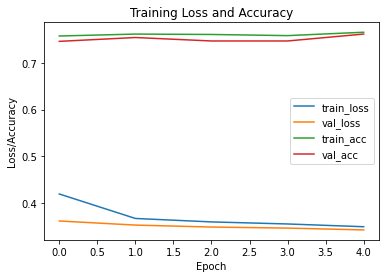

In [16]:
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [17]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


63/63 [==============================] - 0s 3ms/step - loss: 0.3554 - accuracy: 0.7542
Test loss: 0.355392724275589
Test accuracy: 0.7542288303375244


In [18]:
idx = 0
model.predict(x_test[idx:idx+1], verbose=1)


1/1 [==============================] - 0s 79ms/step


array([[1.5114596e-04, 9.9984884e-01]], dtype=float32)

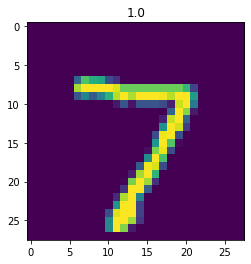

In [19]:
plt.figure()
plt.title(y_test[idx][1])
plt.imshow(np.squeeze(x_test[idx]))
plt.show()

# Exemplar Model

In [20]:
num_exemplars = 20

In [21]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_exemplars, activation="sigmoid")
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)               

## Define a custom loss class


In [22]:
class CustomExemplarLoss(keras.losses.Loss):
    def __init__(self, opt=1, name="custom_exemplar_loss"):
        super().__init__(name=name)
        self.opt = opt # Just a placeholder at the moment

    def call(self, y_true, y_pred):
        # mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        # reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        # return mse + reg * self.regularization_factor

        # y_true should be 1 number (0 or 1)
        # y_pred should be N numbers (predictions)

        # Find the difference of each prediction from gt
        # with any luck, tf will auto expand y_true
        diff = tf.abs(y_true - y_pred)

        # Find the min difference along the last axis (columns)
        loss = tf.math.reduce_min(diff, axis=-1)

        return loss


In [23]:
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomExemplarLoss(), metrics=["accuracy"])
batch_size = 128
epochs = 5

model.fit(x_train, y_train[:,1], batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
86/86 [==============================] - 1s 6ms/step - loss: 0.0874 - accuracy: 0.7144 - val_loss: 1.2750e-07 - val_accuracy: 0.7713
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 1.8522e-07 - accuracy: 0.7562 - val_loss: 1.2434e-07 - val_accuracy: 0.7713
Epoch 3/5
86/86 [==============================] - 0s 4ms/step - loss: 2.0279e-07 - accuracy: 0.7654 - val_loss: 1.2200e-07 - val_accuracy: 0.7713
Epoch 4/5
86/86 [==============================] - 0s 4ms/step - loss: 2.3298e-07 - accuracy: 0.7597 - val_loss: 1.1876e-07 - val_accuracy: 0.7713
Epoch 5/5
86/86 [==============================] - 0s 4ms/step - loss: 2.0597e-07 - accuracy: 0.7601 - val_loss: 1.1484e-07 - val_accuracy: 0.7713


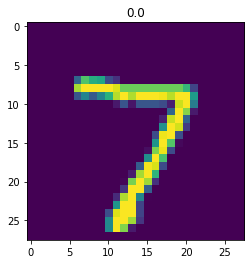

In [24]:
idx = 0

plt.figure()
plt.title(y_train[idx][1])
plt.imshow(np.squeeze(x_test[idx]))
plt.show()


[9.3720555e-01 9.9999988e-01 2.4794083e-04 9.9800235e-01 4.3286827e-01
 9.0032034e-02 6.9347090e-01 6.5193182e-01 8.3065301e-02 9.7704530e-01
 3.6036872e-04 9.8691815e-01 5.7985795e-01 9.6212190e-01 9.9992085e-01
 9.9996459e-01 7.8257698e-01 8.9067739e-01 2.3897942e-07 5.8143145e-01]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


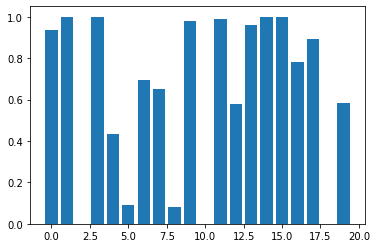

In [25]:
preds = model.predict(x_train[idx:idx+1])[0]
bins = np.arange(len(preds))
print(preds)
print(bins)
plt.bar(bins, preds)
plt.show()


1/1 [==============================] - 0s 12ms/step


TypeError: ignored

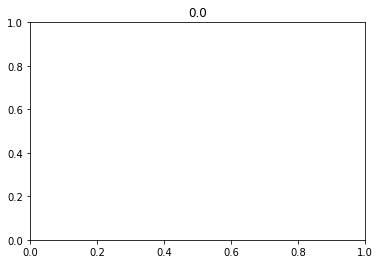

In [26]:
preds = model.predict(x_train[idx:idx+1], verbose=1)

plt.figure()
plt.title(y_train[idx][1])
plt.bar(np.arange(len(preds)), preds)
plt.show()
